In [1]:
import argparse
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# !pip install wandb -qU
# !pip install ml_collections
import modulus
import data_generator as dg
import default
import wandb

In [3]:
torch.manual_seed(123)

In [4]:
'''

Уравнение гармонического осцилятора
m*d^2x/d^2t + mu * dx/dt + kx = 0

m = 1  - масса
d(delta) = 2
w0 = 20
mu = 2 * d
k = w0**2
Граничные условия
x0_bc = 1
dx_dt0_bc = 0

'''

'\n\nУравнение гармонического осцилятора\nm*d^2x/d^2t + mu * dx/dt + kx = 0\n\nm = 1  - масса\nd(delta) = 2\nw0 = 20\nmu = 2 * d\nk = w0**2\nГраничные условия\nx0_bc = 1\ndx_dt0_bc = 0\n\n'

In [5]:
def oscillator(x, d=2, w0=20):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


def equation(yhp, x_physics, d=2, w0=20):
    mu = d * 2
    k = w0 ** 2
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    physics = dx2 + mu*dx + k*yhp
    return physics

In [6]:
class TrainClass:
    def __init__(self, cfg, model, wandbFlag=False):
        self.num_t = cfg.num_t
        self.num_ph = cfg.num_ph
        
        self.num_epochs = cfg.epochs
        self.num_hidden_layers = 4
        self.save_path = cfg.save_path
        
        self.num_nodes = cfg.hidden_sizes
        self.learning_rate = cfg.lr
        self.wandbFlag = wandbFlag
        if self.wandbFlag:
          self.__wandbConnect(cfg)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Operation mode: ", self.device)

        # Данные
        self.__createData()
        
        # Модель
        self.model = model.to(self.device)
        
        # Оптимизатор
        # self.optimizer = torch.optim.Adam(self.model.parameters(), betas=(0.999, 0.999), lr=self.learning_rate)
        self.optimizer = torch.optim.Adam(model.parameters(),betas=(0.9, 0.999),lr=self.learning_rate)
        # Логирование
        self.loss_history = []
        self.l2_history = []
        self.best_loss = float('inf')
        self.best_epoch = 0
    
    
    '''    
    Подключается к wandb для отслеживания процесса обучения
    '''
    def __wandbConnect(self, cfg):
        wandb.login()
        wandb.init(
            project=cfg.project,
            name=cfg.name,
            config={
            "epochs": cfg.epochs,
            })
        
    '''
    Генерирует данные:
    variables - выборка, содержищие граничные и начальные условия
    variables_f - выборка из t
    t - содержит все точки оси t
    '''
    def __createData(self):
        self.x, self.x_data, self.x_physics = dg.generator(self.num_t, self.num_ph)
        self.x = torch.FloatTensor(self.x)
        self.x_data = torch.FloatTensor(self.x_data)
        self.x_physics = torch.FloatTensor(self.x_physics).requires_grad_(True)
        self.y = oscillator(self.x).view(-1,1)
        self.y_data = self.y[0:len(self.x)//2:len(self.x)//20]
        plt.figure()
        plt.plot(self.x, self.y, label="Exact solution")
        plt.scatter(self.x_data, self.y_data, color="tab:orange", label="Training data")
        plt.legend()
        plt.show()

    def __calculate_l2_error(self):

        u_pred = self.model(self.x)
        u_pred = u_pred.cpu().detach().numpy()
        true=self.y.cpu().detach().numpy()
        # Сравнение с эталоном
        error = np.linalg.norm(u_pred - true, 2) / np.linalg.norm(true, 2)
        return error

        
    '''
    Выводит график вычисленного уравнения
    xp - тестовые точки для нейросети(для отображения)
    yh - выходные точки нейросети от self.x
    '''
    def printEval(self,epoch=None):
        
        self.model.load_state_dict(torch.load(self.save_path, map_location=torch.device(self.device)))

        print("L2 error: ", self.__calculate_l2_error())
        u_pred = self.model(self.x).detach()
        u_pred = u_pred.cpu().numpy()
        
        xp = self.x_physics.detach()
        
        "Pretty plot training results"
        plt.figure(figsize=(8,4))
        plt.plot(self.x,self.y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
        plt.plot(self.x, u_pred, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
        plt.scatter(self.x_data, self.y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
        l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
        plt.setp(l.get_texts(), color="k")
        plt.xlim(-0.05, 1.05)
        plt.ylim(-1.1, 1.1)
        if epoch != None:
            plt.text(1.065,0.7,"Training step: %i"%(epoch+1),fontsize="xx-large",color="k")
        plt.axis("off")

    '''
    Выводит график функции потерь, а также эпоху с наименьшей величиной потерь
    '''
    def printLossGraph(self):
        print(f"[Best][Epoch: {self.best_epoch}] Train loss: {self.best_loss}")
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title("loss")
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.l2_history)
        plt.title("L2 loss")

        plt.show()
        
    def train(self):
        d, w0 = 2, 20
        mu, k = 2*d, w0**2

        for epoch in tqdm(range(self.num_epochs)):
            self.optimizer.zero_grad()
            
            # compute the "data loss"
            yh = self.model(self.x_data)
            loss1 = torch.mean((yh-self.y_data)**2)# use mean squared error
            
            # compute the "physics loss"
            yhp = self.model(self.x_physics)
            physics = equation(yhp, self.x_physics)
            loss2 = (1e-4)*torch.mean(physics**2)
            
        
            loss = loss1 + loss2
            # if(epoch % 400 == 0):
            #     print(epoch, loss.item(), self.__calculate_l2_error())
            
            loss.backward()
            self.optimizer.step()

            current_loss = loss.item()
            self.loss_history.append(current_loss)
            l2_error = self.__calculate_l2_error()
            self.l2_history.append(l2_error)

            # Сохранение лучшей модели
            if current_loss < self.best_loss:
                self.best_loss = current_loss
                self.best_epoch = epoch
                torch.save(self.model.state_dict(), self.save_path)

            
            if(epoch % 400 == 0):
                print(f"Epoch {epoch}, Train loss: {current_loss}, L2: {l2_error}")
                
                if self.wandbFlag:
                  wandb.log({"epoche": epoch, "loss": current_loss})
                  wandb.log({"epoche": epoch, "L2": l2_error})
            if epoch % 1000 == 0:   
                self.printEval(epoch)
                
        self.printLossGraph()



/home/maksim/Calculation-module-based-on-PINN-neural-network-architecture/.venv/lib64/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Operation mode:  cpu


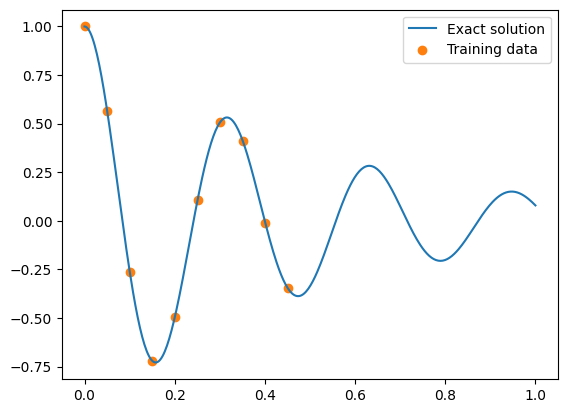

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_51049/695280133.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_

Epoch 0, Train loss: 0.6046290397644043, L2: 1.0491433143615723
L2 error:  1.0491433


  4%|▍         | 394/10000 [00:08<01:51, 86.10it/s] 

Epoch 400, Train loss: 0.26937761902809143, L2: 0.9981337785720825


  8%|▊         | 800/10000 [00:19<02:31, 60.61it/s]

Epoch 800, Train loss: 0.26847416162490845, L2: 0.9967719316482544


 10%|█         | 1007/10000 [00:25<03:02, 49.18it/s]

L2 error:  0.99606484


 12%|█▏        | 1223/10000 [00:28<01:23, 105.13it/s]

Epoch 1200, Train loss: 0.2677815854549408, L2: 0.9953795671463013


 16%|█▌        | 1621/10000 [00:36<02:02, 68.16it/s] 

Epoch 1600, Train loss: 0.26736778020858765, L2: 0.9941763281822205


 20%|██        | 2018/10000 [00:44<01:28, 90.29it/s]

Epoch 2000, Train loss: 0.2671211361885071, L2: 0.9933107495307922
L2 error:  0.99331075


 24%|██▍       | 2406/10000 [00:51<03:40, 34.39it/s] 

Epoch 2400, Train loss: 0.2668333053588867, L2: 0.9927281737327576


 28%|██▊       | 2816/10000 [00:59<01:25, 84.22it/s]

Epoch 2800, Train loss: 0.266140878200531, L2: 0.9920046329498291


 30%|██▉       | 2993/10000 [01:01<01:04, 109.43it/s]

L2 error:  0.9911326


 32%|███▏      | 3211/10000 [01:04<01:56, 58.21it/s] 

Epoch 3200, Train loss: 0.26426810026168823, L2: 0.9896416068077087


 36%|███▌      | 3618/10000 [01:08<00:53, 119.51it/s]

Epoch 3600, Train loss: 0.2620658874511719, L2: 0.9855605959892273


 40%|████      | 4034/10000 [01:12<00:37, 161.04it/s]

Epoch 4000, Train loss: 0.25884121656417847, L2: 0.9793806672096252
L2 error:  0.97938067


 44%|████▍     | 4430/10000 [01:14<00:29, 191.86it/s]

Epoch 4400, Train loss: 0.25380802154541016, L2: 0.9687660336494446


 48%|████▊     | 4827/10000 [01:16<00:26, 198.71it/s]

Epoch 4800, Train loss: 0.24793587625026703, L2: 0.9540369510650635


 50%|█████     | 5040/10000 [01:17<00:24, 204.75it/s]

L2 error:  0.94564104


 52%|█████▏    | 5236/10000 [01:18<00:23, 206.82it/s]

Epoch 5200, Train loss: 0.2421720027923584, L2: 0.9366421699523926


 56%|█████▋    | 5627/10000 [01:20<00:22, 193.68it/s]

Epoch 5600, Train loss: 0.23432928323745728, L2: 0.9145903587341309


 60%|██████    | 6009/10000 [01:22<00:27, 143.66it/s]

Epoch 6000, Train loss: 0.2144082635641098, L2: 0.8718209266662598
L2 error:  0.8718209


 64%|██████▍   | 6435/10000 [01:24<00:18, 195.63it/s]

Epoch 6400, Train loss: 0.18032775819301605, L2: 0.7811707258224487


 68%|██████▊   | 6821/10000 [01:26<00:15, 201.88it/s]

Epoch 6800, Train loss: 0.16724011301994324, L2: 0.7296754121780396


 70%|███████   | 7027/10000 [01:27<00:15, 195.33it/s]

L2 error:  0.7149538


 72%|███████▏  | 7227/10000 [01:28<00:14, 193.84it/s]

Epoch 7200, Train loss: 0.14776749908924103, L2: 0.6858140826225281


 76%|███████▋  | 7637/10000 [01:30<00:11, 199.43it/s]

Epoch 7600, Train loss: 0.08744320273399353, L2: 0.52882319688797


 80%|████████  | 8023/10000 [01:32<00:10, 192.73it/s]

Epoch 8000, Train loss: 0.034824173897504807, L2: 0.3675421476364136
L2 error:  0.36754215


 84%|████████▍ | 8420/10000 [01:34<00:09, 158.44it/s]

Epoch 8400, Train loss: 0.02031780406832695, L2: 0.3000674247741699


 88%|████████▊ | 8825/10000 [01:37<00:06, 188.42it/s]

Epoch 8800, Train loss: 0.016314148902893066, L2: 0.26435524225234985


 90%|█████████ | 9028/10000 [01:38<00:05, 180.80it/s]

L2 error:  0.25392395


 92%|█████████▏| 9232/10000 [01:39<00:03, 200.20it/s]

Epoch 9200, Train loss: 0.015055377967655659, L2: 0.24651139974594116


 96%|█████████▌| 9621/10000 [01:41<00:01, 189.61it/s]

Epoch 9600, Train loss: 0.014337457716464996, L2: 0.23691928386688232


100%|██████████| 10000/10000 [01:43<00:00, 96.81it/s]


[Best][Epoch: 9999] Train loss: 0.013719248585402966


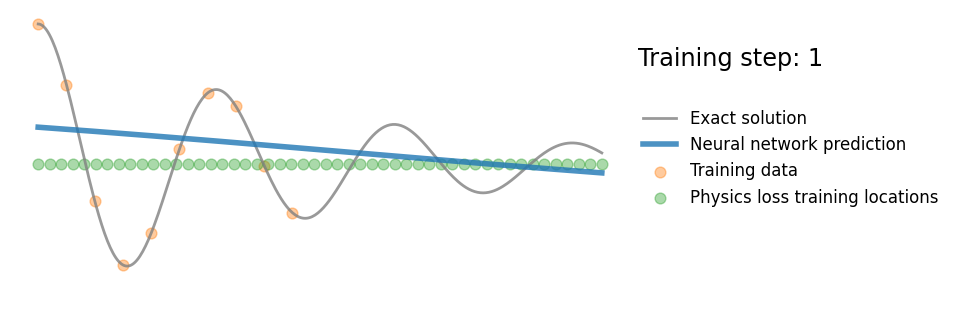

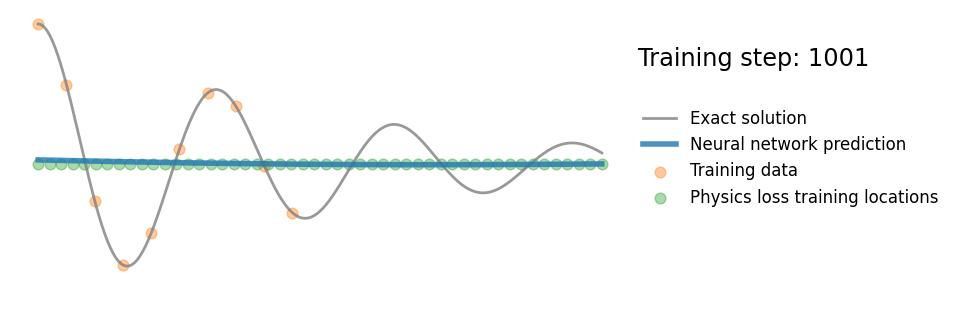

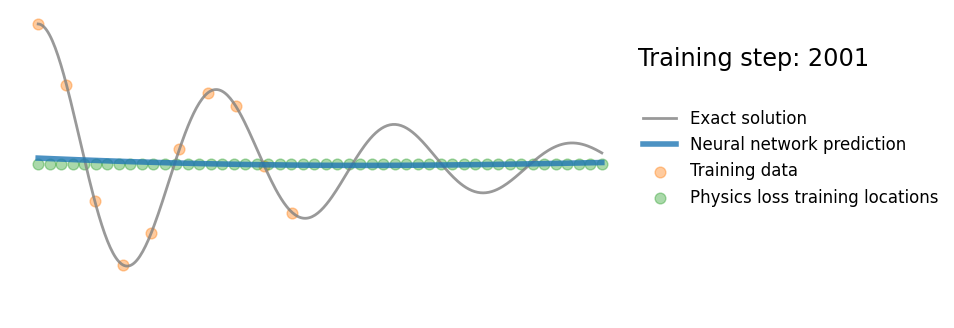

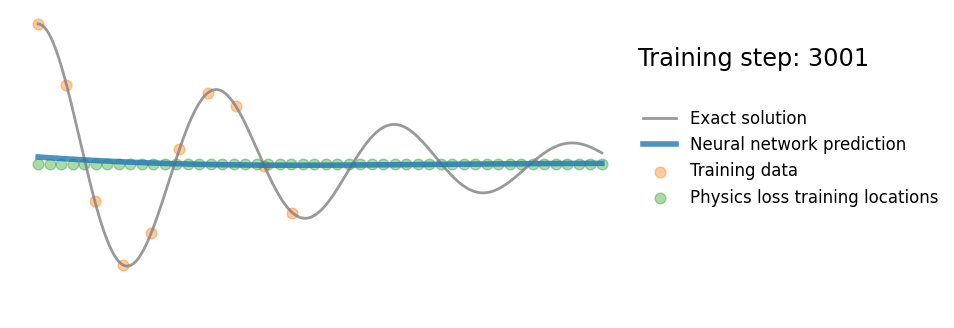

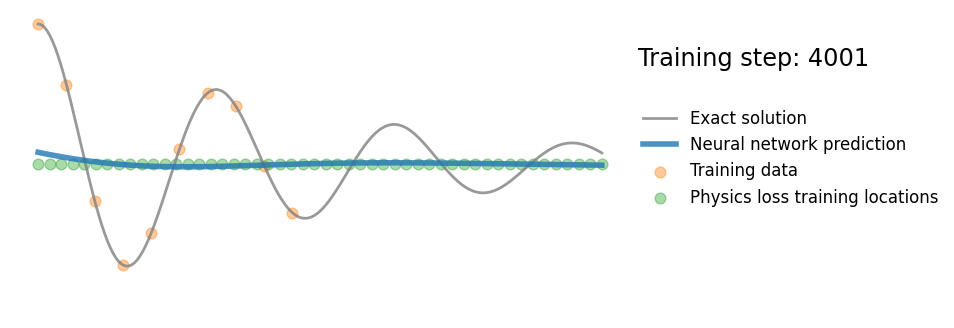

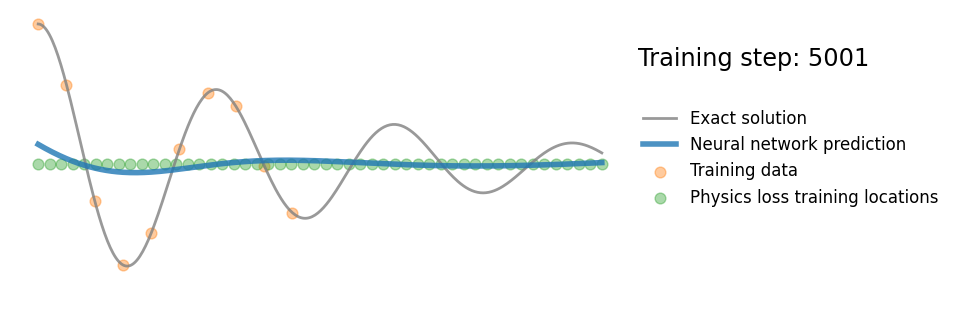

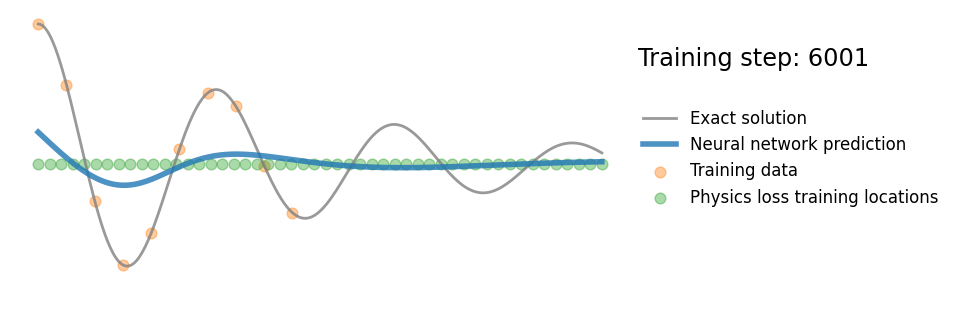

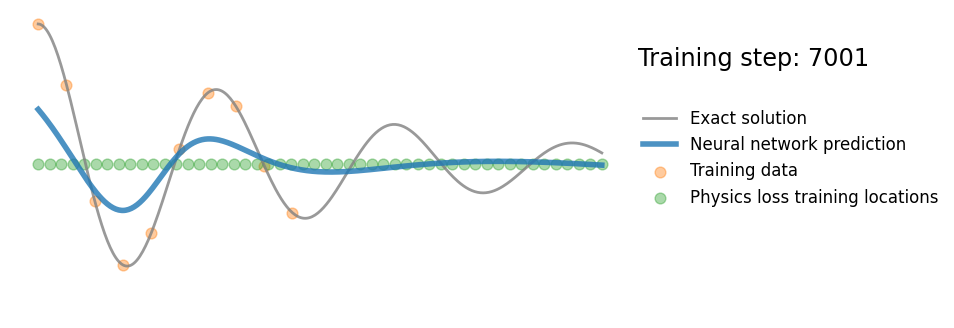

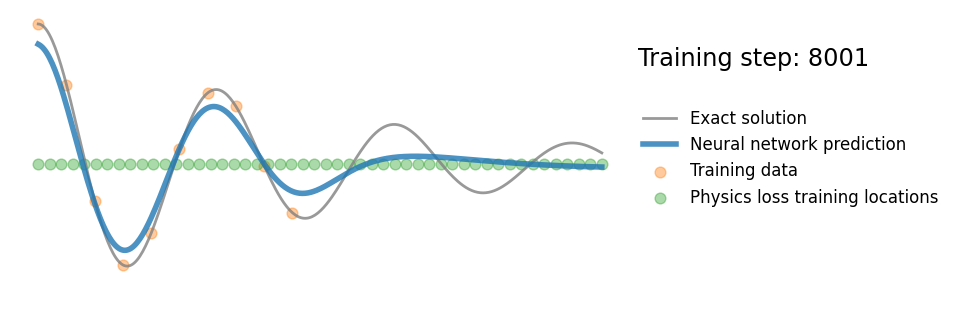

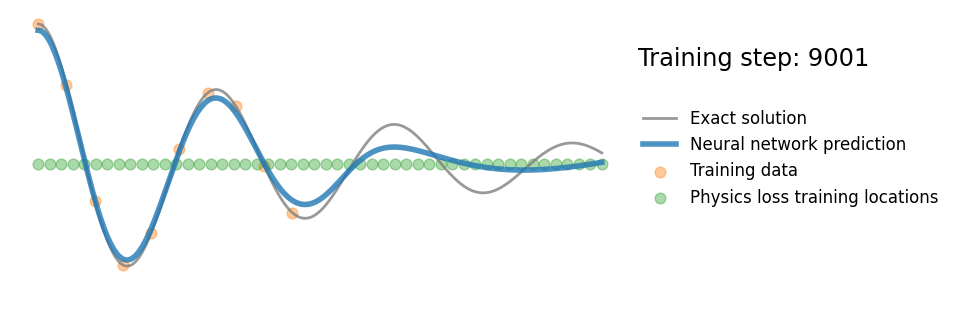

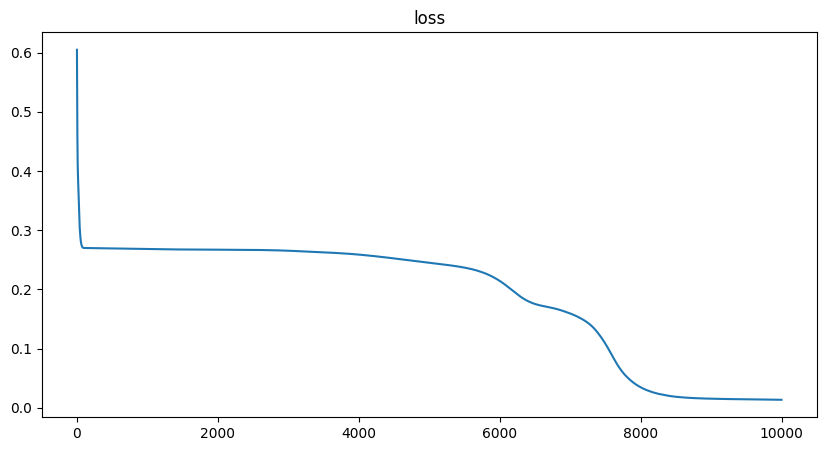

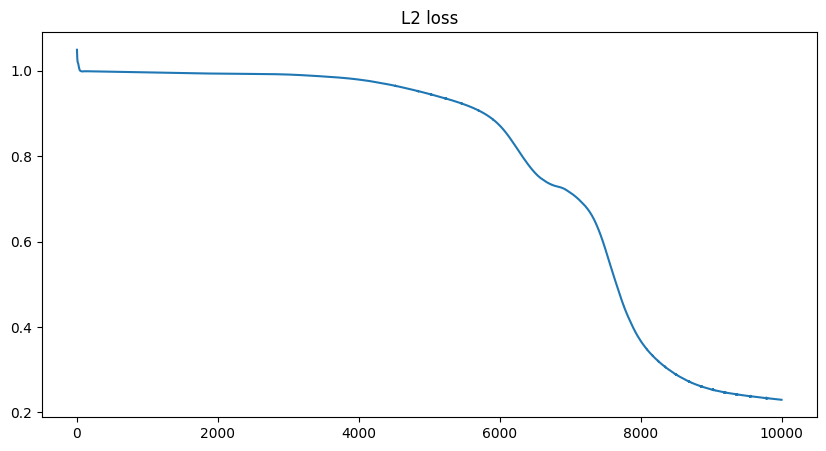

L2 error:  0.2295039


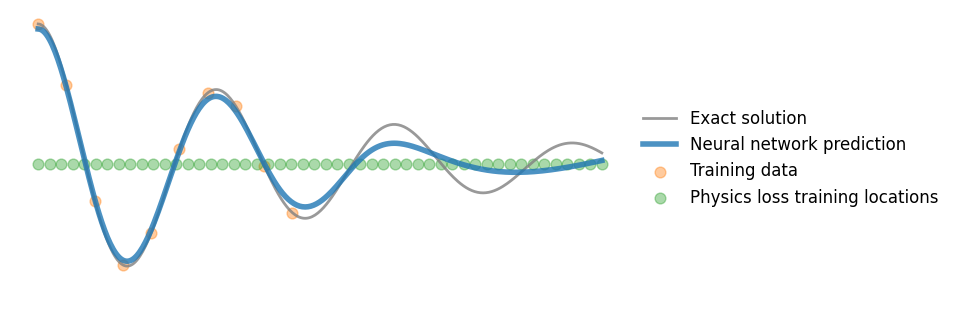

In [7]:
import default
import cfg_test1
import cfg_test2
import cfg_test3
import cfg_test4

hyperparameters = default.get_config()
# hyperparameters = cfg_test1.get_config()
# hyperparameters = cfg_test2.get_config()
# hyperparameters = cfg_test3.get_config()
# hyperparameters = cfg_test4.get_config()

model = modulus.pinn(hyperparameters)
a = TrainClass(hyperparameters, model)
a.train()
a.printEval()
# a.printLossGraph()
# a.train()